In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:

import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [3]:

# Load the existing HDF5 model
model = tf.keras.models.load_model('model/keypoint_classifier/keypoint_classifier.hdf5')

# Save it in .keras format
model.save('model/keypoint_classifier/keypoint_classifier.keras')
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'

# 分類数設定

In [4]:
NUM_CLASSES = 6

# 学習データ読み込み

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,136 (4.44 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
print(tf.__version__)  # Should output '2.11.0'

2.16.1


In [11]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [16]:
print("Model output shape:", model.output_shape)

# 2. Check your labels format
print("Unique y_train values:", np.unique(y_train))
print("y_train shape:", y_train.shape)

Model output shape: (None, 6)
Unique y_train values: [0 1 2 3 4 5]
y_train shape: (4065,)


In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True  # Helps debug by disabling graph mode
)

In [18]:
# Check for invalid values
print("Max value in X_train:", np.max(X_train))
print("Min value in X_train:", np.min(X_train))
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())

Max value in X_train: 1.0
Min value in X_train: -1.0
NaN in X_train: False
Inf in X_train: False


# モデル訓練

In [19]:
try:
    history = model.fit(
        X_train.astype(np.float32),
        y_train,
        epochs=10,  # Start with fewer epochs
        batch_size=32,  # Reduced from 128
        validation_data=(X_test.astype(np.float32), y_test),
        callbacks=[cp_callback, es_callback],
        verbose=1
    )
except Exception as e:
    print("Detailed error:", str(e))
    raise

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2418 - loss: 1.7357 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.2422 - loss: 1.7350 - val_accuracy: 0.4214 - val_loss: 1.4582
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3966 - loss: 1.4633
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.3966 - loss: 1.4631 - val_accuracy: 0.5284 - val_loss: 1.2986
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4637 - loss: 1.3451
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.4637 - loss: 1.3451 - val_accuracy: 0.6465 - val_loss: 1.1799
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5027 - loss: 1.2754
Epoch 4: saving model to model/keypoint_classifier/keypoint_clas

In [20]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8325 - loss: 0.7495


In [31]:
# 保存したモデルのロード
model_save_path='model/keypoint_classifier/keypoint_classifier.keras'
model = tf.keras.models.load_model(model_save_path)

In [32]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[0.03789493 0.2500314  0.6583928  0.00208269 0.02138055 0.03021769]
2


# 混同行列

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


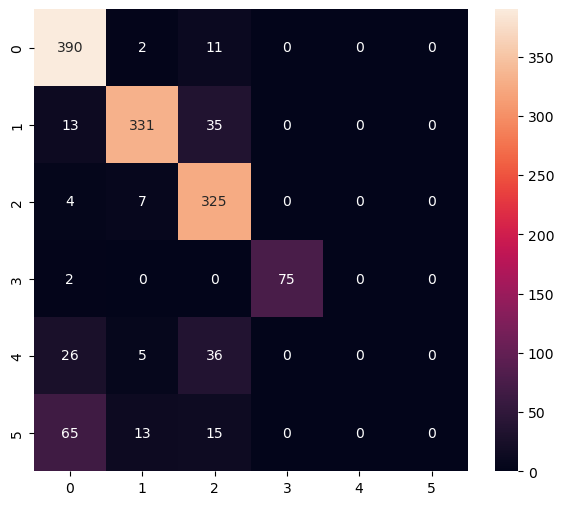

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       403
           1       0.92      0.87      0.90       379
           2       0.77      0.97      0.86       336
           3       1.00      0.97      0.99        77
           4       0.00      0.00      0.00        67
           5       0.00      0.00      0.00        93

    accuracy                           0.83      1355
   macro avg       0.58      0.63      0.60      1355
weighted avg       0.74      0.83      0.78      1355



C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [34]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [35]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

AttributeError: 'Sequential' object has no attribute '_get_save_spec'

# 推論テスト

In [36]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [37]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [38]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [39]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [40]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.0227847e-02 1.8926211e-01 7.8040773e-01 1.0241032e-04]
2


Training samples per class:
 0    1119
1    1193
2    1020
3     260
4     196
5     277
Name: count, dtype: int64


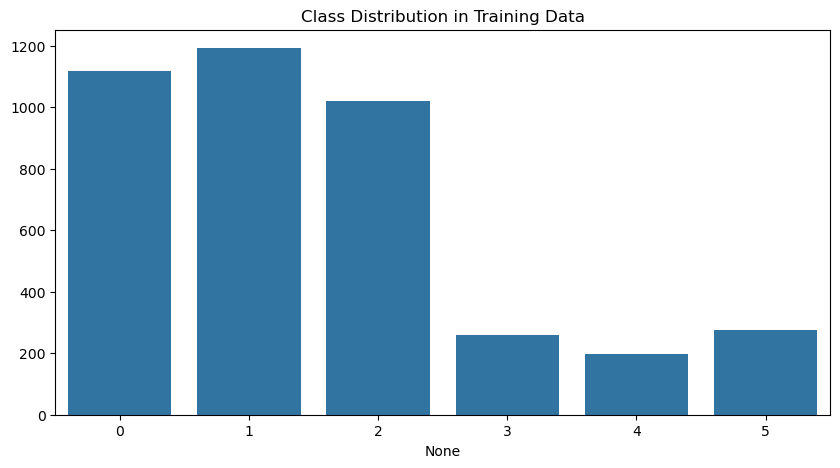

In [41]:
# Check sample counts per class
class_counts = pd.Series(y_train).value_counts().sort_index()
print("Training samples per class:\n", class_counts)

# Visualize class distribution
plt.figure(figsize=(10,5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution in Training Data")
plt.show()

In [42]:
# Rebuild model with class weighting
total_samples = len(y_train)
class_weights = {
    0: total_samples/(6*class_counts[0]),
    1: total_samples/(6*class_counts[1]),
    2: total_samples/(6*class_counts[2]),
    3: total_samples/(6*class_counts[3]),
    4: total_samples/(6*class_counts[4]),  # Higher weight for rare classes
    5: total_samples/(6*class_counts[5])
}

# Verify weights
print("Class weights:", class_weights)

Class weights: {0: 0.6054512957998213, 1: 0.5678960603520536, 2: 0.6642156862745098, 3: 2.605769230769231, 4: 3.4566326530612246, 5: 2.4458483754512637}


In [51]:
# Save final model with custom objects
tf.keras.models.save_model(model, 'optimized_model.keras', 
                          
                          include_optimizer=True)